# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Introduction to Data Science

## Lab 10: Attention, Self-Attention, Transformers, Text Classification using Language Models 

**Harvard University**<br/>
**Spring 2022**<br/>
**Instructors**: Mark Glickman & Pavlos Protopapas<br/>
**Authors**: Shivas Jayaram

<br/>
---


## Learning Objectives

By the end of this Lab, you will understand:
* How **Attention** works in Sequence to Sequence models
* **Self-Attention** and the **Transformer** architecture
* An **end-to-end** deep learning experiment tracking for a **Text Classification** task using **Language Models** including **BERT** (Bidirectional Encoder Representations from Transformers)
* **Extras**: How to use **GPT2**(Generative Pre-Training) for language generation tasks and how to fine-tune on a custom dataset 


<a id="contents"></a>

## Notebook Contents

- [**Sequence to Sequence with Attention**](#attention)
- [**Self-Attention & Transformers**](#transformers)   
- [**Text Classification using Language Models**](#classification) 
- [**Text Generation using GPT2**](#gpt)      

## **<font color="#A41034">Setup Notebook</font>**

**Installs**

We will install Huggingface’s transformers library. This library let us import a wide range of transformer-based pre-trained models. In our case, we will use BERT & GPT2.

In [1]:
!pip install transformers

Defaulting to user installation because normal site-packages is not writeable


**Imports**

In [1]:
# Import necessary libraries
import os
import time
import datetime
import requests
import json
import re
import random
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

# Tensorflow
import tensorflow as tf
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils.layer_utils import count_params

# sklearn
from sklearn.model_selection import train_test_split

# Transformers
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig
from transformers import GPT2Tokenizer, TFGPT2LMHeadModel, GPT2Config

/opt/conda/envs/tensorflow/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


**Verify Setup**

It is a good practice to verify what version of TensorFlow & Keras you are using. Also verify if GPU is enabled and what GPU you have. Run the following cells to check the version of TensorFlow

References:
- [Eager Execution](https://www.tensorflow.org/guide/eager)
- [Data Performance](https://www.tensorflow.org/guide/data_performance)

In [2]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:GPU:0', device_type='GPU')]
GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2022-04-19 00:17:34.029764: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 00:17:34.036607: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 00:17:34.036955: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-04-19 00:17:34.037799: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Check what GPU you have

In [3]:
!nvidia-smi

Tue Apr 19 00:17:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 470.57.02    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:1E.0 Off |                    0 |
| N/A   47C    P0    26W /  70W |  14885MiB / 15109MiB |      2%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#### **Utils**

Here are some util functions that we will be using for this notebook

In [4]:
# ================
# mainly used for third part
# ================

class JsonEncoder(json.JSONEncoder):
  def default(self, obj):
    if isinstance(obj, np.integer):
        return int(obj)
    elif isinstance(obj, np.floating):
        return float(obj)
    elif isinstance(obj, decimal.Decimal):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    else:
        return super(JsonEncoder, self).default(obj)

experiment_name = None
def create_experiment():
  global experiment_name
  experiment_name = "experiment_" + str(int(time.time()))

  # Create experiment folder
  if not os.path.exists(experiment_name):
      os.mkdir(experiment_name)

def save_data_details(data_details):
  with open(os.path.join(experiment_name,"data_details.json"), "w") as json_file:
    json_file.write(json.dumps(data_details,cls=JsonEncoder))

def save_model(model,model_name="model01"):

  if isinstance(model,TFBertForSequenceClassification):
    model.save_weights(os.path.join(experiment_name,model_name+".h5"))
  else:
    # Save the enitire model (structure + weights)
    model.save(os.path.join(experiment_name,model_name+".hdf5"))

    # Save only the weights
    model.save_weights(os.path.join(experiment_name,model_name+".h5"))

    # Save the structure only
    model_json = model.to_json()
    with open(os.path.join(experiment_name,model_name+".json"), "w") as json_file:
        json_file.write(model_json)

def get_model_size(model_name="model01"):
  model_size = os.stat(os.path.join(experiment_name,model_name+".h5")).st_size
  return model_size

def evaluate_save_model(model,test_data, training_results,execution_time, learning_rate, batch_size, epochs, optimizer,save=True):
    
  # Get the model train history
  model_train_history = training_results.history
  # Get the number of epochs the training was run for
  num_epochs = len(model_train_history["loss"])

  # Plot training results
  fig = plt.figure(figsize=(15,5))
  axs = fig.add_subplot(1,2,1)
  axs.set_title('Loss')
  # Plot all metrics
  for metric in ["loss","val_loss"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()
  
  axs = fig.add_subplot(1,2,2)
  axs.set_title('Accuracy')
  # Plot all metrics
  for metric in ["accuracy","val_accuracy"]:
      axs.plot(np.arange(0, num_epochs), model_train_history[metric], label=metric)
  axs.legend()

  plt.show()
  
  # Evaluate on test data
  evaluation_results = model.evaluate(test_data)
  print(evaluation_results)
  
  if save:
    # Save model
    save_model(model, model_name=model.name)
    model_size = get_model_size(model_name=model.name)

    # Save model history
    with open(os.path.join(experiment_name,model.name+"_train_history.json"), "w") as json_file:
        json_file.write(json.dumps(model_train_history,cls=JsonEncoder))

    trainable_parameters = count_params(model.trainable_weights)
    non_trainable_parameters = count_params(model.non_trainable_weights)

    # Save model metrics
    metrics ={
        "trainable_parameters":trainable_parameters,
        "execution_time":execution_time,
        "loss":evaluation_results[0],
        "accuracy":evaluation_results[1],
        "model_size":model_size,
        "learning_rate":learning_rate,
        "batch_size":batch_size,
        "epochs":epochs,
        "name": model.name,
        "optimizer":type(optimizer).__name__
    }
    with open(os.path.join(experiment_name,model.name+"_model_metrics.json"), "w") as json_file:
        json_file.write(json.dumps(metrics,cls=JsonEncoder))

## **Sequence to Sequence with Attention**

### **Overview**

The aim of this section is to build and train a Seq2Seq model with attention

**The Task:** Perform Neural Machine Translation from english to spanish. We will also create a analysis model to create a sentence to sentence heat-map

**NOTE:** For this section, we will modify the attention, by not combining it with the previous input to the decoder, but instead concatenating it with the current hidden state of the decoder. This is not as effective as the Bahdanau attention but greatly simplifies the execution.

The equation transforms from: 

$$
c_{i}=\sum_{j=1}^{T_{x}} \alpha_{i j}\left(h_{i-1}^{D}, h_{j}^{E}\right) h_{j}^{E}
$$

to:

$$
c_{i}=\sum_{j=1}^{T_{x}} \alpha_{i j}\left(h_{i}^{D}, h_{j}^{E}\right) h_{j}^{E}
$$

### **Dataset**

The dataset consists of English to Spanish translations from http://www.manythings.org/ 



**Load Data**

Load the english to spanish dataset

In [5]:
# Read the English to Spanish datafile into a pandas dataframe
# Use columns [0,1] with tab as the seperator, no head
# Set the names of the columns as "English" and "Spanish"
file_url = 'https://storage.googleapis.com/cs109b/nlp/spa.txt'
data = pd.read_csv(file_url, sep='\t', header=None, usecols=[0,1], names=['English', 'Spanish'])

In [6]:
# Take a quick look of the dataset
print("Shape:",data.shape)
data.head(10)

Shape: (118964, 2)


,English,Spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
5,Run!,¡Corre!
6,Run.,Corred.
7,Who?,¿Quién?
8,Fire!,¡Fuego!
9,Fire!,¡Incendio!


**Add Start/End Tokens**

Add start `<s>` and end `</s>` tokens to each word

In [7]:
# For each English and Spanish sentence in the dataframe 
# add the start <s> and end </s> tokens
data.Spanish = '<s> '+data.Spanish+' </s>'
data.English = '<s> '+data.English+' </s>'

In [8]:
data.head(10)

,English,Spanish
0,<s> Go. </s>,<s> Ve. </s>
1,<s> Go. </s>,<s> Vete. </s>
2,<s> Go. </s>,<s> Vaya. </s>
3,<s> Go. </s>,<s> Váyase. </s>
4,<s> Hi. </s>,<s> Hola. </s>
5,<s> Run! </s>,<s> ¡Corre! </s>
6,<s> Run. </s>,<s> Corred. </s>
7,<s> Who? </s>,<s> ¿Quién? </s>
8,<s> Fire! </s>,<s> ¡Fuego! </s>
9,<s> Fire! </s>,<s> ¡Incendio! </s>


### **Build Data Pipelines**

**Text Tokenization**

In [9]:
# Specify the maximum size of the vocabulary of English words as 5000
vocab_size_eng = 5000

# Specify the maximum size of the vocabulary of Spanish word as 5000
vocab_size_spa = 5000

# Create tokenizer objects for both languages with appropriate choices
tokenizer_eng = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size_eng,
                                                      lower=True, 
                                                      char_level=False, 
                                                      oov_token=None, 
                                                      filters='!"#$%&()*+,-.:;=?@[\\]^_`{|}~\t\n')

# For spanish, make sure to also filter out the special spanish token ¡ and ¿ commonly used in formal spanish
tokenizer_spa = tf.keras.preprocessing.text.Tokenizer(num_words=vocab_size_spa,
                                                      lower=True, 
                                                      char_level=False, 
                                                      oov_token=None, 
                                                      filters='¡!"#$%&()*+,-.:;=¿?@[\\]^_`{|}~\t\n')

In [10]:
# Fit both tokenizers on all the text in the dataframe for each language 
tokenizer_eng.fit_on_texts(data.English)
tokenizer_spa.fit_on_texts(data.Spanish)

In [11]:
# Get the integer sequence corresponding to both tokenizers 
input_eng = tokenizer_eng.texts_to_sequences(data.English)
input_spa = tokenizer_spa.texts_to_sequences(data.Spanish)

View some tokenized text

In [12]:
print("English:",input_eng[0])
print("Spanish:",input_spa[0])

English: [1, 42, 2]
Spanish: [1, 366, 2]


**Create TF Datasets**

In [13]:
batch_size = 512
train_shuffle_buffer_size = 5000

# Write a mapping function to process the input data
# The english doesn't need to be processed any further, as we will process the entire sentences.
# Since we are using the decoder to predict the next word, the target language must be processed. 
# The source data and target must be shifted by one position
def process(eng, spa):
    in_spa  = spa[:,:-1]
    out_spa = spa[:,1:]
    
    in_eng  = eng.to_tensor(default_value=0, shape=[None, None])
    in_spa  = in_spa.to_tensor(default_value=0, shape=[None, None])
    out_spa = out_spa.to_tensor(default_value=0, shape=[None, None]) 
    return (in_eng, in_spa), out_spa

# Use tensorflow ragged constants to get the ragged version of data
train_processed_x = tf.ragged.constant(input_eng)
train_processed_y = tf.ragged.constant(input_spa)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((train_processed_x, train_processed_y))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(process, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(AUTOTUNE)

print("train_data",train_data)

train_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, None), dtype=tf.int32, name=None), TensorSpec(shape=(None, None), dtype=tf.int32, name=None)), TensorSpec(shape=(None, None), dtype=tf.int32, name=None))>


In [14]:
# View some data from tf dataset
for (ip_eng,ip_spa),output in train_data.take(1):
  print(ip_eng.shape,ip_spa.shape,output.shape)
  
  print("Input English:",ip_eng[0])
  print("Input Spanish:",ip_spa[0])
  print("Output Spanish:",output[0])
  print("****************")
  print("Input English:")
  print(tokenizer_eng.sequences_to_texts([ip_eng[0].numpy()]))
  print("Input Spanish:")
  print(tokenizer_spa.sequences_to_texts([ip_spa[0].numpy()]))
  print("Output Spanish:")
  print(tokenizer_spa.sequences_to_texts([output[0].numpy()]))

(512, 6) (512, 8) (512, 8)
Input English: tf.Tensor([   1   84   31 2398    2    0], shape=(6,), dtype=int32)
Input Spanish: tf.Tensor([   1  110    5   76 2151    0    0    0], shape=(8,), dtype=int32)
Output Spanish: tf.Tensor([ 110    5   76 2151    2    0    0    0], shape=(8,), dtype=int32)
****************
Input English:
["<s> i'll be brief </s>"]
Input Spanish:
['<s> voy a ser breve']
Output Spanish:
['voy a ser breve </s>']


### **Build Seq2Seq with Attention Model**

In [15]:
def build_model(evaluation_model=False):
  # Model input
  inputs_eng = tf.keras.Input(shape=[None])
  inputs_spa = tf.keras.Input(shape=[None])

  # Encoder
  emb_eng = tf.keras.layers.Embedding(input_dim=tokenizer_eng.num_words+1, 
                                    output_dim = 128, 
                                    mask_zero=True,
                                    name='Encoder_embedding')(inputs_eng)
  encoder_states = tf.keras.layers.GRU(128, return_sequences=True, name='Encoder_RNN_f')(emb_eng)
  last_encoder_state = encoder_states[:,-1,:]

  # Decoder
  emb_spa = tf.keras.layers.Embedding(input_dim=tokenizer_spa.num_words+1, 
                                    output_dim = 128, 
                                    mask_zero=True,
                                    name='Decoder_embedding')(inputs_spa)
  decoder_states = tf.keras.layers.GRU(128, return_sequences=True,  name='Decoder_RNN')(emb_spa)

  # Create projections for the encoder and decoder hidden states 
  hidden_size=64
  r_encoder = tf.keras.layers.Dense(hidden_size, activation=None, use_bias=False)(encoder_states)
  r_decoder = tf.keras.layers.Dense(hidden_size, activation=None, use_bias=False)(decoder_states)

  # Compute Attention
  # Step 1:
  # Expand the dimensions for the query and the value at the appropriate locations 
  query = tf.expand_dims(r_decoder, axis=2)
  value = tf.expand_dims(r_encoder, axis=1)

  # Step 2:
  # Compute the score as in Bahdanau's paper  
  score = tf.reduce_sum(tf.tanh(query + value, name='Score'), axis=-1)


  # Additional step:
  # It is crucial to manually mask the 'padded' hidden states otherwise there will be 
  # a mismatch between the encoder-decoder model defined above
  # And the attention weights computed below 
  N_query = tf.reduce_sum(tf.cast(inputs_spa>0, tf.float32), axis=1)
  query_mask = tf.sequence_mask(N_query)

  N_value = tf.reduce_sum(tf.cast(inputs_eng>0, tf.float32), axis=1)
  value_mask = tf.sequence_mask(N_value)

  # Mask the score
  m1 = tf.sequence_mask(N_query, dtype=tf.float32)
  m2 = tf.sequence_mask(N_value, dtype=tf.float32)

  score = tf.transpose(tf.multiply(tf.transpose(score,[2,0,1]), m1),[1,2,0])
  score = tf.transpose(tf.multiply(tf.transpose(score,[1,0,2]), m2), [1,0,2])

  # Step 3: Use the scores to get a distribution of probabilities
  weights = tf.nn.softmax(score, axis=2, name='Weights')

  # Step 4: Compute the context vector by multiplying the encoder states with the weights 
  context_vector = tf.matmul(weights, encoder_states)

  # Concatenate the context vector with the decoder states 
  enhanced_encoding = tf.keras.layers.Concatenate(axis=2)([context_vector, decoder_states])

  # Pass the enhanced encoding to a dense layer with softmax activation 
  output_spa = tf.keras.layers.Dense(tokenizer_spa.num_words+1,activation='softmax')(enhanced_encoding)

  # Set up the model with appropriate inputs and the output defined above 
  model = tf.keras.Model(inputs=(inputs_eng, inputs_spa), outputs=output_spa)

  # Build another evaluation model that will give us the associated weights
  # We will use this for visualization
  evaluation_model = tf.keras.Model(inputs=(inputs_eng, inputs_spa), outputs=[weights,inputs_eng,inputs_spa])

  return model, evaluation_model

### **Train**

In [ ]:
############################
# Training Params
############################
learning_rate = 5e-3
epochs = 50

# Free up memory
tf.keras.backend.clear_session()

# Build the model
model, evaluation_model = build_model()

# Print the model architecture
#print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Epoch 1/50
233/233 [==============================] - 13s 26ms/step - loss: 2.5266
Epoch 2/50
233/233 [==============================] - 6s 26ms/step - loss: 1.6038
Epoch 3/50
233/233 [==============================] - 6s 26ms/step - loss: 0.9613
Epoch 4/50
233/233 [==============================] - 6s 26ms/step - loss: 0.7350
Epoch 5/50
233/233 [==============================] - 6s 26ms/step - loss: 0.6277
Epoch 6/50
233/233 [==============================] - 6s 25ms/step - loss: 0.5608
Epoch 7/50
233/233 [==============================] - 6s 26ms/step - loss: 0.5091
Epoch 8/50
233/233 [==============================] - 6s 26ms/step - loss: 0.4688
Epoch 9/50
233/233 [==============================] - 6s 26ms/step - loss: 0.4419
Epoch 10/50
233/233 [==============================] - 6s 25ms/step - loss: 0.4151
Epoch 11/50
233/233 [==============================] - 6s 25ms/step - loss: 0.3960
Epoch 12/50
233/233 [==============================] - 6s 26ms/step - loss: 0.3744
Epoch 13/50


### **Evalute Model**

Now use the evalution model to output the weights and visualize them

In [ ]:
for batch in train_data.take(1):
  (ip_eng,ip_spa),output = batch
  print(ip_eng.shape,ip_spa.shape,output.shape)

  print("Input English:")
  print(tokenizer_eng.sequences_to_texts([ip_eng[0].numpy()]))
  print("Input Spanish:")
  print(tokenizer_spa.sequences_to_texts([ip_spa[0].numpy()]))
  print("Output Spanish:")
  print(tokenizer_spa.sequences_to_texts([output[0].numpy()]))

# Use the evaluation model to get the weights and associated sentences in both languages  
alphas,eng,spa = evaluation_model((ip_eng,ip_spa))

(512, 6) (512, 7) (512, 7)
Input English:
['<s> i love beer </s>']
Input Spanish:
['<s> me encanta la cerveza']
Output Spanish:
['me encanta la cerveza </s>']


In [ ]:
# Size we get an entire batch as output, pick one for a particular sentence
sentence=0
base_eng_sentence = eng[sentence].numpy()
base_spa_sentence = spa[sentence].numpy()
scores = alphas[sentence].numpy()
# Remove mask 0
b_eng = base_eng_sentence>0
b_spa = base_spa_sentence>0
eng_sentence = base_eng_sentence[b_eng]
spa_sentence = base_spa_sentence[b_spa]
# Make sure to adjust for the tokens 
spa_sentence = spa_sentence[1:]
eng_sentence = eng_sentence[:-1]

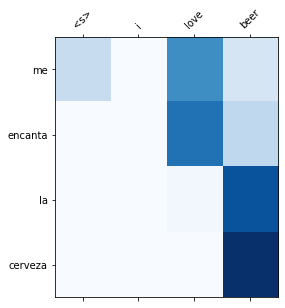

In [ ]:
# Plot your results 
plt.matshow(scores, aspect='auto', cmap=plt.get_cmap('Blues'))
plt.ylim(spa_sentence.shape[0]-0.5,0-0.5)
spa_words = tokenizer_spa.sequences_to_texts([spa_sentence[::-1]])[0].split(' ')
plt.yticks(ticks = range(spa_sentence.shape[0])[::-1], labels=spa_words, rotation = 0)

plt.xlim(0-0.5,eng_sentence.shape[0]-0.5)
eng_words = tokenizer_eng.sequences_to_texts([eng_sentence])[0].split(' ')

plt.xticks(ticks = range(eng_sentence.shape[0]), labels=eng_words, rotation = 45)

plt.show()

### **Analyse Model Architecure**

In [15]:
inputs_eng = tf.keras.Input(shape=[None])
inputs_spa = tf.keras.Input(shape=[None])
emb_eng = tf.keras.layers.Embedding(input_dim=tokenizer_eng.num_words+1, 
                                    output_dim = 128, 
                                    mask_zero=True,
                                    name='Encoder_embedding')(inputs_eng)
encoder_states = tf.keras.layers.GRU(128, return_sequences=True, name='Encoder_RNN_f')(emb_eng)
last_encoder_state = encoder_states[:,-1,:]

# Decoder
emb_spa = tf.keras.layers.Embedding(input_dim=tokenizer_spa.num_words+1, 
                                  output_dim = 128, 
                                  mask_zero=True,
                                  name='Decoder_embedding')(inputs_spa)
decoder_states = tf.keras.layers.GRU(128, return_sequences=True,  name='Decoder_RNN')(emb_spa)

# Create projections for the encoder and decoder hidden states 
hidden_size=64
r_encoder = tf.keras.layers.Dense(hidden_size, activation=None, use_bias=False)(encoder_states)
r_decoder = tf.keras.layers.Dense(hidden_size, activation=None, use_bias=False)(decoder_states)

# Compute Attention
# Step 1:
# Expand the dimensions for the query and the value at the appropriate locations 
query = tf.expand_dims(r_decoder, axis=2)
value = tf.expand_dims(r_encoder, axis=1)

# Step 2:
# Compute the score as in Bahdanau's paper  
score = tf.reduce_sum(tf.tanh(query + value, name='Score'), axis=-1)

N_query = tf.reduce_sum(tf.cast(inputs_spa>0, tf.float32), axis=1)
query_mask = tf.sequence_mask(N_query)

N_value = tf.reduce_sum(tf.cast(inputs_eng>0, tf.float32), axis=1)
value_mask = tf.sequence_mask(N_value)

# Mask the score
m1 = tf.sequence_mask(N_query, dtype=tf.float32)
m2 = tf.sequence_mask(N_value, dtype=tf.float32)

score = tf.transpose(tf.multiply(tf.transpose(score,[2,0,1]), m1),[1,2,0])
score = tf.transpose(tf.multiply(tf.transpose(score,[1,0,2]), m2), [1,0,2])

weights = tf.nn.softmax(score, axis=2, name='Weights')

context_vector = tf.matmul(weights, encoder_states)
# Concatenate the context vector with the decoder states 
enhanced_encoding = tf.keras.layers.Concatenate(axis=2)([context_vector, decoder_states])

# Pass the enhanced encoding to a dense layer with softmax activation 
output_spa = tf.keras.layers.Dense(tokenizer_spa.num_words+1,activation='softmax')(enhanced_encoding)

outputs = [emb_eng, encoder_states, last_encoder_state, 
           emb_spa, decoder_states, r_encoder, r_decoder, query, value, score, 
           weights, context_vector, enhanced_encoding, output_spa]

model = tf.keras.Model(inputs=(inputs_eng, inputs_spa), outputs=outputs)

#print(model.summary())

op = model.predict(train_data.take(1))
print("emb_eng",op[0].shape , "[batch size, sequence length english, embedding dim]")
print("encoder_states", op[1].shape, "[batch size, sequence length english, embedding dim]")
print("last_encoder_state", op[2].shape, "[batch size, embedding dim]")
print("****")
print("emb_spa",op[3].shape , "[batch size, sequence length spanish, embedding dim]")
print("decoder_states", op[4].shape, "[batch size, sequence length spanish, embedding dim]")
print("****")
print("r_encoder", op[5].shape, "[batch size, sequence length english, projection size]")
print("r_decoder", op[6].shape, "[batch size, sequence length spanish, projection size]")
print("****")
print("query", op[7].shape, "[batch size, sequence length spanish, 1, projection size]")
print("value", op[8].shape, "[batch size, 1, sequence length english, projection size]")
print("****")
print("score", op[9].shape, "[batch size,sequence length spanish, sequence length english]")
print("weights", op[10].shape, "[batch size, sequence length spanish, sequence length english]")
print("****")
print("context_vector", op[11].shape, "[batch size, sequence length spanish, encoder_states->embedding dim ]")
print("enhanced_encoding", op[12].shape, 
      "[batch size, sequence length spanish, encoder_states->embedding dim + decoder_states->embedding dim]")
print("output_spa", op[13].shape, "[batch size, sequence length spanish, vocabulary size+1]")

2022-04-16 02:46:03.378334: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8100


emb_eng (512, 6, 128) [batch size, sequence length english, embedding dim]
encoder_states (512, 6, 128) [batch size, sequence length english, embedding dim]
last_encoder_state (512, 128) [batch size, embedding dim]
****
emb_spa (512, 7, 128) [batch size, sequence length spanish, embedding dim]
decoder_states (512, 7, 128) [batch size, sequence length spanish, embedding dim]
****
r_encoder (512, 6, 64) [batch size, sequence length english, projection size]
r_decoder (512, 7, 64) [batch size, sequence length spanish, projection size]
****
query (512, 7, 1, 64) [batch size, sequence length spanish, 1, projection size]
value (512, 1, 6, 64) [batch size, 1, sequence length english, projection size]
****
score (512, 7, 6) [batch size,sequence length spanish, sequence length english]
weights (512, 7, 6) [batch size, sequence length spanish, sequence length english]
****
context_vector (512, 7, 128) [batch size, sequence length spanish, encoder_states->embedding dim ]
enhanced_encoding (512, 7

## **Self-Attention & Transformers**

### **Overview**

The aim of this section is to build and train a Transformer model from scratch. For this, we will be using an English to Spanish translation dataset. We are going to perform machine translation from english to spanish using an encoder decoder architecture. 

**The Task:** Perform Neural Machine Translation from english to spanish.



### **Dataset**

The dataset consists of English to Spanish translations from http://www.manythings.org/ 



**Load Data**

Load the english to spanish dataset

In [16]:
# Read the English to Spanish datafile into a pandas dataframe
# Use columns [0,1] with tab as the seperator, no head
# Set the names of the columns as "English" and "Spanish"
file_url = 'https://storage.googleapis.com/cs109b/nlp/spa.txt'
data = pd.read_csv(file_url, sep='\t', header=None, usecols=[0,1], names=['English', 'Spanish'])

In [17]:
# Take a quick look of the dataset
print("Shape:",data.shape)
data.head(10)

Shape: (118964, 2)


,English,Spanish
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
5,Run!,¡Corre!
6,Run.,Corred.
7,Who?,¿Quién?
8,Fire!,¡Fuego!
9,Fire!,¡Incendio!


**Add Start/End Tokens**

Add start `<s>` and end `</s>` tokens to each word

In [18]:
# For Spanish sentence in the dataframe 
# add the start <s> and end </s> tokens
data.Spanish = '<s> '+data.Spanish+' </s>'

In [19]:
data.head(10)

,English,Spanish
0,Go.,<s> Ve. </s>
1,Go.,<s> Vete. </s>
2,Go.,<s> Vaya. </s>
3,Go.,<s> Váyase. </s>
4,Hi.,<s> Hola. </s>
5,Run!,<s> ¡Corre! </s>
6,Run.,<s> Corred. </s>
7,Who?,<s> ¿Quién? </s>
8,Fire!,<s> ¡Fuego! </s>
9,Fire!,<s> ¡Incendio! </s>


**Split Data** 
We split data into train and test by randomly selecting 10% as the test set.

In [20]:
test_percent = 0.10

data_en = data.English.values
data_sp = data.Spanish.values

# Split data into train / validate
split_outputs = train_test_split(data_en, data_sp, test_size=test_percent)
train_en, test_en, train_sp, test_sp = split_outputs

print("train_en count:",len(train_en))
print("test_en count:",len(test_en))
print("train_en count:",len(train_sp))
print("test_en count:",len(test_sp))

train_en count: 107067
test_en count: 11897
train_en count: 107067
test_en count: 11897


### **Build Data Pipelines**

**Text Vectorization**

[Reference](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/TextVectorization)


In [22]:
vocab_size = 5000
sequence_length = 20

# Build a function to clean spanish text
# Convert to lower case
# filter out the special spanish token ¡ and ¿ commonly used in formal spanish
strip_chars = '!"#$%&\'()*+,-.:;=?@[\]^_`{|}~¿¡'
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

vectorization_eng = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)
vectorization_spa = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

In [23]:
# Fit both vectorizations on all the text in the dataframe for each language 
vectorization_eng.adapt(data.English)
vectorization_spa.adapt(data.Spanish)

View some tokenized text

In [24]:
for idx in range(5):
  print("English:",vectorization_eng(data.English[idx]))
  print("Spanish:",vectorization_spa(data.Spanish[idx]))

English: tf.Tensor([41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
Spanish: tf.Tensor(
[  2 368   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0], shape=(21,), dtype=int64)
English: tf.Tensor([41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
Spanish: tf.Tensor(
[   2 1329    3    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0], shape=(21,), dtype=int64)
English: tf.Tensor([41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
Spanish: tf.Tensor(
[  2 504   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0], shape=(21,), dtype=int64)
English: tf.Tensor([41  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
Spanish: tf.Tensor([2 1 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(21,), dtype=int64)
English: tf.Tensor(
[2271    0    0    0    0    0    0

**Create TF Datasets**

In [25]:
batch_size = 256
train_shuffle_buffer_size = 5000

# Write a mapping function to process the input data
# First vectorize both english and spanish.
# Since we are using the decoder to predict the next word, the target language must be processed. 
# The source data and target must be shifted by one position
def process(eng, spa):
    eng = vectorization_eng(eng)
    spa = vectorization_spa(spa)
    return (eng,spa[:, :-1]), spa[:, 1:]    # shift input and outputs

# Create TF Dataset
#train_data = tf.data.Dataset.from_tensor_slices((data.English, data.Spanish))
train_data = tf.data.Dataset.from_tensor_slices((train_en, train_sp))
test_data = tf.data.Dataset.from_tensor_slices((test_en, test_sp))

#############
# Train data
#############
# Apply all data processing logic
train_data = train_data.shuffle(buffer_size=train_shuffle_buffer_size)
train_data = train_data.batch(batch_size)
train_data = train_data.map(process, num_parallel_calls=AUTOTUNE)
train_data = train_data.prefetch(AUTOTUNE)

#############
# Test data
#############
# Apply all data processing logic
test_data = test_data.batch(batch_size)
test_data = test_data.map(process, num_parallel_calls=AUTOTUNE)
test_data = test_data.prefetch(AUTOTUNE)

print("train_data",train_data)
print("test_data",test_data)

train_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, 20), dtype=tf.int64, name=None), TensorSpec(shape=(None, 20), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))>
test_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, 20), dtype=tf.int64, name=None), TensorSpec(shape=(None, 20), dtype=tf.int64, name=None)), TensorSpec(shape=(None, 20), dtype=tf.int64, name=None))>


In [26]:
# View some data from tf.data dataset
for (ip_eng,ip_spa),output in train_data.take(1):
  print(ip_eng.shape,ip_spa.shape,output.shape)
  
  print("Input English:",ip_eng[0])
  print("Input Spanish:",ip_spa[0])
  print("Output Spanish:",output[0])
  print("****************")

(256, 20) (256, 20) (256, 20)
Input English: tf.Tensor([15  5 16 97 48  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
Input Spanish: tf.Tensor([ 2 40 59  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
Output Spanish: tf.Tensor([40 59  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0], shape=(20,), dtype=int64)
****************


### **Build Transformer Model**

**Positional Encoding**

Build a function to encode positions using the following technical details:

<img src="https://storage.googleapis.com/public_colab_images/nlp/positional-encoding-math.png" width="600"/>

In [27]:
def generate_positional_encoding(max_length, model_size):
    pos_enc = np.array(
        [
            [pos / np.power(10000, 2 * (j // 2) / model_size) for j in range(model_size)]
            if pos != 0
            else np.zeros(model_size)
            for pos in range(max_length)
        ]
    )
    pos_enc[1:, 0::2] = np.sin(pos_enc[1:, 0::2])  # dim 2i
    pos_enc[1:, 1::2] = np.cos(pos_enc[1:, 1::2])  # dim 2i+1
    return pos_enc

**PositionalEmbedding Layer**

We will build an positional embedding layer the combines token embedding as well as the postinal encoding

<img src="https://storage.googleapis.com/public_colab_images/nlp/positional-encoding-layer.png" width="800px"/>

In [28]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim):
      super().__init__()

      # Layer parameters
      self.sequence_length = sequence_length
      self.input_dim = input_dim
      self.output_dim = output_dim

      # Token embedding Layer
      self.token_embeddings = tf.keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim)

      # self.positional_embeddings = tf.keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim)

    def call(self, inputs):
      # Generate token embeddings
      embedded_tokens = self.token_embeddings(inputs)
      # Add positional encoding to the token embedding
      return embedded_tokens + generate_positional_encoding(self.sequence_length,self.output_dim)  # comment this out

      # embedded_positions = self.positional_embeddings(inputs)
      # return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        return tf.math.not_equal(inputs, 0)

**Encoder Layer**

We will build an encoder layer based on the following architecture

<img src="https://storage.googleapis.com/public_colab_images/nlp/transformer_layer.png" width="800px"/>

In [29]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()
        # Layer parameters
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # MultiHeadAttention Layer - Self Attention
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        # Normalization Layer
        self.attention_norm = tf.keras.layers.LayerNormalization()

        # Dense projection
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(units=dense_dim, activation="relu"),
             tf.keras.layers.Dense(units=embed_dim)]
        )
        # Normalization Layer
        self.dense_projection_norm = tf.keras.layers.LayerNormalization()

    def call(self, inputs, mask=None):
        # Apply mask
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        
        # Compute Self Attention
        self_attention = self.attention(query=inputs, value=inputs, key=inputs, attention_mask=mask)
        # Apply Normalization + Residual connection
        self_attention = self.attention_norm(inputs + self_attention)

        # Apply projection
        layer_output = self.dense_proj(self_attention)
        # Apply Normalization + Residual connection
        layer_output = self.dense_projection_norm(self_attention + layer_output)
        return layer_output

**Decoder Layer**

We will build a decoder layer based on the following architecture

<img src="https://storage.googleapis.com/public_colab_images/nlp/decoder_layer.png" width="800px"/>

In [30]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super().__init__()
        # Layer parameters
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        # MultiHeadAttention Layer - Self Attention
        self.attention_1 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        # Normalization Layer
        self.attention_1_norm = tf.keras.layers.LayerNormalization()

        # MultiHeadAttention Layer - Encoder-Decoder Attention
        self.attention_2 = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim//num_heads)
        # Normalization Layer
        self.attention_2_norm = tf.keras.layers.LayerNormalization()

        # Dense projection
        self.dense_proj = tf.keras.Sequential(
            [tf.keras.layers.Dense(units=dense_dim, activation="relu"),
             tf.keras.layers.Dense(units=embed_dim)]
        )
        # Normalization Layer
        self.dense_projection_norm = tf.keras.layers.LayerNormalization()

        # Set supports_masking to ensures that the layer will propagate its input mask to its outputs
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        # Get Causal Attention Mask
        causal_mask = self.get_causal_attention_mask(inputs)
        # Apply Padding Masks
        if mask is not None:
            padding_mask = tf.cast(mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        
        # Compute Self Attention
        self_attention = self.attention_1(query=inputs,
                                          value=inputs,
                                          key=inputs,
                                          attention_mask=causal_mask)
        # Apply Normalization + Residual connection
        self_attention = self.attention_1_norm(inputs + self_attention)

        # Compute Encoder-Decoder Attention
        encoder_decoder_attention = self.attention_2(query=self_attention,
                                              value=encoder_outputs,
                                              key=encoder_outputs,attention_mask=padding_mask)
        # Apply Normalization + Residual connection
        encoder_decoder_attention = self.attention_2_norm(self_attention + encoder_decoder_attention)

        # Apply projection
        layer_output = self.dense_proj(encoder_decoder_attention)
        # Apply Normalization + Residual connection
        layer_output = self.dense_projection_norm(encoder_decoder_attention + layer_output)
        return layer_output
    
    def get_causal_attention_mask(self, inputs):
        """
        Method to generates a causal mask:
        Since the decoder looks at the entire sequence at once, we need to mask the future
        """
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = tf.range(sequence_length)[:, tf.newaxis]
        j = tf.range(sequence_length)
        mask = tf.cast(i >= j, dtype="int32")
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1, 1], dtype=tf.int32)], axis=0)
        return tf.tile(mask, mult)

In [31]:
def build_transformer_model(vocab_size, embedding_dim, num_heads, dense_dim):

  # Model input
  inputs_eng = tf.keras.Input(shape=[None])
  inputs_spa = tf.keras.Input(shape=[None])

  # Build the Encoder
  encoder_ip = PositionalEmbedding(sequence_length, vocab_size, embedding_dim)(inputs_eng)
  encoder_op = EncoderLayer(embedding_dim, dense_dim, num_heads)(encoder_ip) # Stack multiple layers

  # Build the Decoder
  decoder_ip = PositionalEmbedding(sequence_length, vocab_size, embedding_dim)(inputs_spa)
  decoder_op = DecoderLayer(embedding_dim, dense_dim, num_heads)(decoder_ip, encoder_op) # Stack multiple layers
  decoder_op = tf.keras.layers.Dropout(0.4)(decoder_op)

  # Output Layer
  output = tf.keras.layers.Dense(units=vocab_size, activation="softmax")(decoder_op)

  # Create model
  model = tf.keras.Model([inputs_eng, inputs_spa], output)

  return model

In [32]:
############################
# Training Params
############################
learning_rate = 0.001
epochs = 15
embedding_dim = 256
dense_dim = 2048
num_heads = 8

# Free up memory
tf.keras.backend.clear_session()

# Build the model
model = build_transformer_model(vocab_size, embedding_dim, num_heads, dense_dim)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.sparse_categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer)

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 positional_embedding (Position  (None, 20, 256)     1280000     ['input_1[0][0]']                
 alEmbedding)                                                                                     
                                                                                                  
 positional_embedding_1 (Positi  (None, 20, 256)     1280000     ['input_2[0][0]']            

**Make Predictions**

In [33]:
spa_vocab = vectorization_spa.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = sequence_length

def decode_sequence(input_sentence):
    tokenized_input_sentence = vectorization_eng([input_sentence])
    decoded_sentence = "<s>"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = vectorization_spa(
            [decoded_sentence])[:, :-1]
        predictions = model(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "</s>":
            break
    return decoded_sentence

for _ in range(20):
    input_sentence = random.choice(data.English)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
I think I know what the problem is.
<s> creo que sé cuál es el problema </s>
-
They're afraid of us.
<s> ellos les tienen miedo </s>
-
This is our fault.
<s> es culpa nuestra culpa </s>
-
I'm a junior high school student.
<s> soy una [UNK] de [UNK] de grande de [UNK] </s>
-
I don't owe anyone anything.
<s> no te debo nada de nadie </s>
-
I told Tom no.
<s> yo dije a tom no </s>
-
Can you start tomorrow?
<s> puedes empezar mañana </s>
-
He introduced me to his parents.
<s> Él me [UNK] a sus padres </s>
-
Illness prevented me from going out.
<s> la enfermedad me impidió salir </s>
-
Tom smiled at Mary.
<s> tom sonrió a mary </s>
-
We set a trap to catch a fox.
<s> nosotros [UNK] una trampa para un zorro </s>
-
Tom has had enough.
<s> tom ya tiene suficiente </s>
-
I didn't ask to be chosen.
<s> no te pedí ser [UNK] </s>
-
I wish I had known the truth.
<s> ojalá hubiera sabido que ella la verdad </s>
-
Never open the door of a car that is in motion.
<s> nunca [UNK] la puerta de un auto 

## **Text Classification using Language Models**

### **Overview**

In this section, we're going to be working with news articles from CNN. We will explore the dataset, prepare the data for modeling, and try different models, which includes simple networks, networks with embeddings, networks with pretrained embeddings and BERT.

**The Task:** Classify news articles into three categories, namely politics, health, and entertainment.

### **Dataset**

The dataset consists of news articles pulled from CNN in the politics, health, and entertainment categories. There are about 300 articles in each category. 

**Download**

Download the datasets to colab.

In [34]:
start_time = time.time()
# Dowload
dataset_path = tf.keras.utils.get_file(
    origin="https://github.com/dlops-io/datasets/releases/download/v1.0/news300.zip",
    extract=True)
dataset_path = dataset_path.replace(".zip","")
print("dataset_path:",dataset_path)
glove_path = tf.keras.utils.get_file(
    origin="https://github.com/shivasj/dataset-store/releases/download/v3.0/glove.6B.100d.txt.zip",
    extract=True)
glove_path = glove_path.replace(".zip","")
print("glove_path:",glove_path)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

2121728/2109041 [==============================] - 0s 0us/step
dataset_path: /home/u_61397728/.keras/datasets/news300
134422528/134409594 [==============================] - 2s 0us/step
glove_path: /home/u_61397728/.keras/datasets/glove.6B.100d.txt
Download execution time (mins) 0.23412856658299763


**Load Data**

* Read-in data as lists.
* Each element in data_x is the content of a sample, namely an news article. 
* Each element in data_y is the label of that article.

In [35]:
# Get the labels from folder names
label_names = os.listdir(dataset_path)

# Number of unique labels
num_classes = len(label_names) 
# Create label index for easy lookup
label2index = dict((name, index) for index, name in enumerate(label_names))
index2label = dict((index, name) for index, name in enumerate(label_names))

print("Number of classes:", num_classes)
print("Labels:", label_names)

# Generate a list of labels and path to text
data_x = []
data_y = []

for label in label_names:
  text_files = os.listdir(os.path.join(dataset_path,label))
  data_x.extend([os.path.join(dataset_path,label,f) for f in text_files])
  data_y.extend([label for f in text_files])

# Load the text content
for idx, path in enumerate(data_x):
  # Load text
  with open(path) as file:
    data_x[idx] = file.read()

# Preview
print("data_x count:",len(data_x))
print("data_y count:",len(data_y))
print("Label counts:",np.unique(data_y, return_counts=True))

Number of classes: 3
Labels: ['health', 'entertainment', 'politics']
data_x count: 920
data_y count: 920
Label counts: (array(['entertainment', 'health', 'politics'], dtype='<U13'), array([310, 310, 300]))


**View Text**

Let's take a look at the data.

In [36]:
# Generate a random sample of index
data_samples = np.random.randint(0,high=len(data_x)-1, size=10)
for i,data_idx in enumerate(data_samples):
  print("Label:",data_y[data_idx],", Text:",data_x[data_idx])

Label: politics , Text: Vulnerable Senate Republicans tie themselves to Barrett with Trump's numbers eroding   (CNN)Endangered Senate Republicans have a new running mate in the battle to keep their narrow majority: Amy Coney Barrett. As President Donald Trump's standing has deteriorated, they are aligning themselves closely with his Supreme Court nominee, hoping their aggressive push to confirm her to the bench before Election Day will be enough to energize their base, fill their campaign coffers and overcome the drag at the top of the ticket. At Tuesday's confirmation hearing, Republicans in tight races in North Carolina, Iowa, Texas and South Carolina were quick to rally to Barrett's defense and are signaling they'll vote to confirm her to the court just days before the November election. Republicans are calculating that getting Barrett on the bench will overcome backlash from voters, given that polls show clear majorities believe that the winner of the November 3 elections should ma

**Split Data** 
We split data into train and validation by randomly selecting 20% as the validation set.

In [37]:
validation_percent = 0.20

# Split data into train / validate
train_x, validate_x, train_y, validate_y = train_test_split(data_x, data_y, test_size=validation_percent)

print("train_x count:",len(train_x))
print("validate_x count:",len(validate_x))

train_x count: 736
validate_x count: 184


In [38]:
# Text processing parameters
max_tokens = 15000
sequence_length = 1000

# Convert all y labels to numbers
train_processed_y = [label2index[label] for label in train_y]
validate_processed_y = [label2index[label] for label in validate_y]

# Converts to y to binary class matrix (One-hot-encoded)
train_processed_y = tf.keras.utils.to_categorical(train_processed_y, num_classes=num_classes, dtype='float32')
validate_processed_y = tf.keras.utils.to_categorical(validate_processed_y, num_classes=num_classes, dtype='float32')

# Create text only tf.data
text_data = tf.data.Dataset.from_tensor_slices(train_x)

### **Text Classificaton Models**

In [40]:
BATCH_SIZE = 32

def build_tf_data(train_x, validate_x, train_processed_y, validate_processed_y, text_vectorizer):  
  
  TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
  VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

  # Vectorize Text
  def vectorize_text(text, label=None):
    text = tf.expand_dims(text, -1)
    text = text_vectorizer(text)
    if label is None:
      return text
    else:
      return text, label

  # Create TF Dataset
  train_data = tf.data.Dataset.from_tensor_slices((train_x, train_processed_y))
  validation_data = tf.data.Dataset.from_tensor_slices((validate_x, validate_processed_y))

  #############
  # Train data
  #############
  train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
  train_data = train_data.batch(BATCH_SIZE)
  train_data = train_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
  train_data = train_data.prefetch(buffer_size=AUTOTUNE)
  train_data = train_data.cache()

  ##################
  # Validation data
  ##################
  validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
  validation_data = validation_data.batch(BATCH_SIZE)
  validation_data = validation_data.map(vectorize_text, num_parallel_calls=AUTOTUNE)
  validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)
  validation_data = validation_data.cache()

  return train_data, validation_data

In [42]:
# Create an experiment (Stores all your models/metrics in a separate folder)
create_experiment()

### **FFN**

* We will start with a simple fully connected neural network. 
* In this model, each layer is a dense layer
* Wer use activation function in  the hidden layers as ReLU. 
* Since our task is a multiclass classification problem, we use softmax as the activation function in the output layer.

In [41]:
# Initialize Text Vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Adapt on text
text_vectorizer.adapt(text_data.batch(64))

# Build tf.data datasets
train_data, validation_data = build_tf_data(train_x, validate_x, train_processed_y, validate_processed_y, text_vectorizer)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <CacheDataset element_spec=(TensorSpec(shape=(None, 1000), dtype=tf.int64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
validation_data <CacheDataset element_spec=(TensorSpec(shape=(None, 1000), dtype=tf.int64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [43]:
def build_simple_fcn(num_classes, sequence_length):
  # Set the model name as
  model_name = 'simple_fcn'

  # Model input
  model_input = tf.keras.layers.Input(shape=(sequence_length))

  hidden = tf.keras.layers.Dense(1024, activation="relu")(model_input)
  hidden = tf.keras.layers.Dense(1024, activation="relu")(hidden)
  hidden = tf.keras.layers.Dense(512, activation="relu")(hidden)
  hidden = tf.keras.layers.Dense(512, activation="relu")(hidden)

  # Output Layer
  output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = tf.keras.Model(inputs=model_input, outputs=output, name=model_name)

  return model

**Train**

Model: "simple_fcn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense (Dense)               (None, 1024)              1025024   
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dense_4 (Dense)             (None, 3)                 1539      
                                                                 
Total params: 2,863,619
Trainable params: 2,863,619
Non-

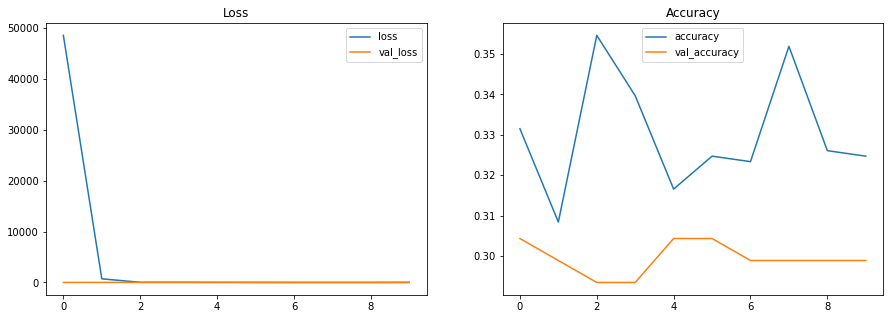

6/6 [==============================] - 0s 2ms/step - loss: 2.8800 - accuracy: 0.2989
[2.8799567222595215, 0.29891303181648254]


In [44]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_simple_fcn(num_classes, sequence_length)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,validation_data, training_results,execution_time, learning_rate, BATCH_SIZE, epochs, optimizer,save=True)

### **FFN: 1-Gram**

In [45]:
# Initialize Text Vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="multi_hot"
)

# Adapt on text
text_vectorizer.adapt(text_data.batch(64))

# Build tf.data datasets
train_data, validation_data = build_tf_data(train_x, validate_x, train_processed_y, validate_processed_y, text_vectorizer)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <CacheDataset element_spec=(TensorSpec(shape=(None, 15000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
validation_data <CacheDataset element_spec=(TensorSpec(shape=(None, 15000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [47]:
def build_binary_1gram_model(num_classes, input_size):
  # Set the model name as
  model_name = 'binary_1gram'

  # Model input
  model_input = tf.keras.layers.Input(shape=(input_size))

  hidden = tf.keras.layers.Dense(1024, activation="relu")(model_input)
  hidden = tf.keras.layers.Dropout(0.4)(hidden)
  hidden = tf.keras.layers.Dense(1024, activation="relu")(hidden)
  hidden = tf.keras.layers.Dropout(0.4)(hidden)
  hidden = tf.keras.layers.Dense(512, activation="relu")(hidden)
  hidden = tf.keras.layers.Dropout(0.4)(hidden)
  hidden = tf.keras.layers.Dense(512, activation="relu")(hidden)
  hidden = tf.keras.layers.Dropout(0.4)(hidden)

  # Output Layer
  output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = tf.keras.Model(inputs=model_input, outputs=output, name=model_name)

  return model

Model: "binary_1gram"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 15000)]           0         
                                                                 
 dense (Dense)               (None, 1024)              15361024  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)              

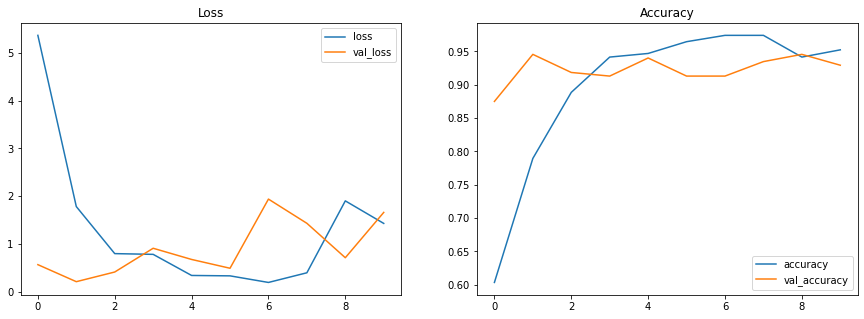

6/6 [==============================] - 0s 3ms/step - loss: 1.6575 - accuracy: 0.9293
[1.6575071811676025, 0.929347813129425]


In [48]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_binary_1gram_model(num_classes, max_tokens)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,validation_data, training_results,execution_time, learning_rate, BATCH_SIZE, epochs, optimizer,save=True)

### **FFN: Bi-Gram**

In [49]:
# Initialize Text Vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(
    ngrams=2,
    max_tokens=max_tokens,
    output_mode="multi_hot"
)

# Adapt on text
text_vectorizer.adapt(text_data.batch(64))

# Build tf.data datasets
train_data, validation_data = build_tf_data(train_x, validate_x, train_processed_y, validate_processed_y, text_vectorizer)

print("train_data",train_data)
print("validation_data",validation_data)

train_data <CacheDataset element_spec=(TensorSpec(shape=(None, 15000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
validation_data <CacheDataset element_spec=(TensorSpec(shape=(None, 15000), dtype=tf.float32, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [50]:
def build_binary_2gram_model(num_classes, input_size):
  # Set the model name as
  model_name = 'binary_2gram'

  # Model input
  model_input = tf.keras.layers.Input(shape=(input_size))

  hidden = tf.keras.layers.Dense(1024, activation="relu")(model_input)
  hidden = tf.keras.layers.Dropout(0.4)(hidden)
  hidden = tf.keras.layers.Dense(1024, activation="relu")(hidden)
  hidden = tf.keras.layers.Dropout(0.4)(hidden)
  hidden = tf.keras.layers.Dense(512, activation="relu")(hidden)
  hidden = tf.keras.layers.Dropout(0.4)(hidden)
  hidden = tf.keras.layers.Dense(512, activation="relu")(hidden)
  hidden = tf.keras.layers.Dropout(0.4)(hidden)

  # Output Layer
  output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = tf.keras.Model(inputs=model_input, outputs=output, name=model_name)

  return model

Model: "binary_2gram"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 15000)]           0         
                                                                 
 dense (Dense)               (None, 1024)              15361024  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 1024)              1049600   
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               524800    
                                                                 
 dropout_2 (Dropout)         (None, 512)              

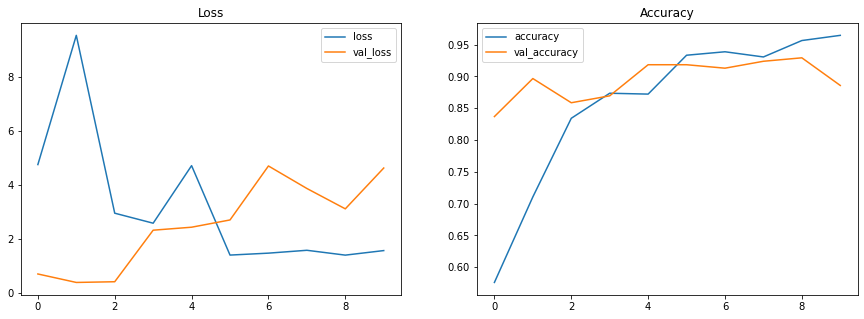

6/6 [==============================] - 0s 3ms/step - loss: 4.6126 - accuracy: 0.8859
[4.612576484680176, 0.885869562625885]


In [51]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10

# Free up memory
K.clear_session()

# Build the model
model = build_binary_2gram_model(num_classes, max_tokens)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,validation_data, training_results,execution_time, learning_rate, BATCH_SIZE, epochs, optimizer,save=True)

### **LSTM: Embedding**

In [52]:
# Initialize Text Vectorizer
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)

# Adapt on text
text_vectorizer.adapt(text_data.batch(64))

# Get Vocabulary
vocabulary = text_vectorizer.get_vocabulary()
vocabulary_size = len(vocabulary)
print("Vocabulary Size:",vocabulary_size)
# Generate word index
word_index = dict(zip(vocabulary, range(vocabulary_size)))

# Build tf.data datasets
train_data, validation_data = build_tf_data(train_x, validate_x, train_processed_y, validate_processed_y, text_vectorizer)

print("train_data",train_data)
print("validation_data",validation_data)

Vocabulary Size: 15000
train_data <CacheDataset element_spec=(TensorSpec(shape=(None, 1000), dtype=tf.int64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
validation_data <CacheDataset element_spec=(TensorSpec(shape=(None, 1000), dtype=tf.int64, name=None), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [53]:
def build_lstm_model_emb(num_classes,vocab_size,embedding_dim,hidden_size):
  # Set the model name as
  model_name = 'lstm_model_emb'

  # Model input
  model_input = tf.keras.Input(shape=(None,))

  # Embedding
  embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim, mask_zero=True)(model_input)

  # LSTM layer
  hidden = tf.keras.layers.LSTM(units=hidden_size, return_sequences=False)(embedding)
  hidden = tf.keras.layers.Dense(units=hidden_size, activation='relu')(hidden)

  # Output Layer
  output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = tf.keras.Model(inputs=model_input, outputs=output, name=model_name)

  return model

Model: "lstm_model_emb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1500000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,546,595
Trainable params: 1,546,595
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
23/23 [===================

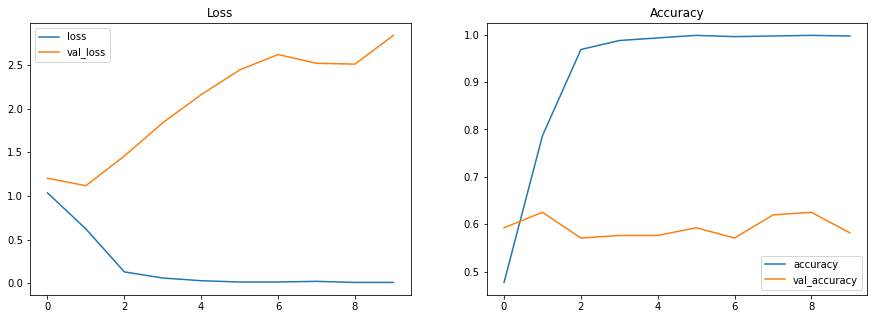

6/6 [==============================] - 0s 18ms/step - loss: 2.8379 - accuracy: 0.5815
[2.837888717651367, 0.58152174949646]


In [54]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10
embedding_dim = 100
hidden_size = 64

# Free up memory
K.clear_session()

# Build the model
model = build_lstm_model_emb(num_classes, max_tokens, embedding_dim,hidden_size)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,validation_data, training_results,execution_time, learning_rate, BATCH_SIZE, epochs, optimizer,save=True)

In [55]:
#del varname

### **LSTM: Pretrained Embedding**

* Alternatively, we could initialize embeddings with pre-trained word embeddings.
* Specifically, let's try GloVe embeddings. GloVe stands for Global Vectors, which is an open-source project developed by Stanford. It contains pre-trained word representations in various sizes, including 50-dimensional, 100-dimensional, 200-dimensional, and 300-dimensional.

* In this model, we choose the 100d version.

[Reference](http://nlp.stanford.edu/projects/glove/)

**Prepare Embedding**

We need to prepare the pretrained embedding to use in our model

In [56]:
# Read glove embeddings
embeddings_index = {}
with open(glove_path) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Number of word vectors:",len(embeddings_index))

Number of word vectors: 400000


In [57]:
# Prepare embedding matrix
embedding_dim = 100
embedding_matrix = np.zeros((max_tokens, embedding_dim))
oov = {}    
n_covered = 0
n_oov = 0
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
      embedding_matrix[i] = embedding_vector
    else:
      n_oov += 1

text_coverage = (vocabulary_size-n_oov)/vocabulary_size
print("Text Coverage:",text_coverage)

print("Embedding Matrix, Shape" ,embedding_matrix.shape)

Text Coverage: 0.9356
Embedding Matrix, Shape (15000, 100)


In [58]:
def build_lstm_pretrained_emb(num_classes,vocab_size,embedding_dim,hidden_size, embedding_matrix):
  # Set the model name as
  model_name = 'lstm_pretrained_emb'

  # Model input
  model_input = tf.keras.Input(shape=(None,))

  # Embedding
  embedding = tf.keras.layers.Embedding(input_dim=embedding_matrix.shape[0], 
                            output_dim=embedding_dim, 
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), # Load pre-trained weights
                            trainable=False, # Set Trainable to False
                            name="embedding")(model_input)

  # LSTM layer
  hidden = tf.keras.layers.LSTM(units=hidden_size, return_sequences=False)(embedding)
  hidden = tf.keras.layers.Dense(units=hidden_size, activation='relu')(hidden)

  # Output Layer
  output = tf.keras.layers.Dense(units=num_classes, activation='softmax')(hidden)

  # Create model
  model = tf.keras.Model(inputs=model_input, outputs=output, name=model_name)

  return model

Model: "lstm_pretrained_emb"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         1500000   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 1,546,595
Trainable params: 46,595
Non-trainable params: 1,500,000
_________________________________________________________________
None
Epoch 1/10
23/23 [=========

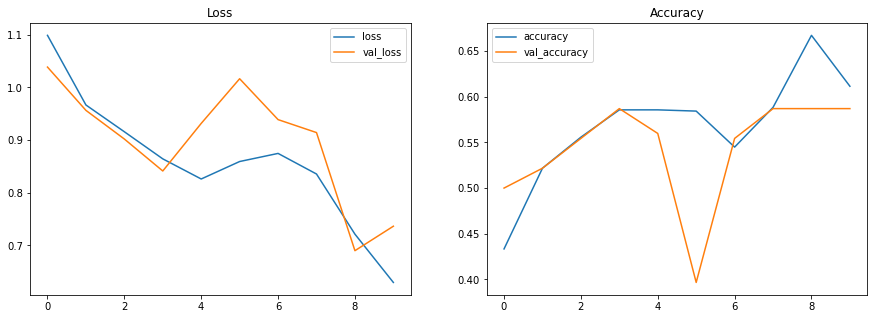

6/6 [==============================] - 0s 16ms/step - loss: 0.7364 - accuracy: 0.5870
[0.7363658547401428, 0.5869565010070801]


In [59]:
############################
# Training Params
############################
learning_rate = 0.01
epochs = 10
embedding_dim = 100
hidden_size = 64

# Free up memory
K.clear_session()

# Build the model
model = build_lstm_pretrained_emb(num_classes, max_tokens, embedding_dim,hidden_size, embedding_matrix)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
# Loss
loss = tf.keras.losses.categorical_crossentropy

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,validation_data, training_results,execution_time, learning_rate, BATCH_SIZE, epochs, optimizer,save=True)

### **Pretrained BERT**

BERT Text Tokenization ([Reference](https://huggingface.co/transformers/model_doc/bert.html#berttokenizer))

In [60]:
# Tokenizer
tokenizer=BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case=True)

Downloading: 100%|██████████| 226k/226k [00:00<00:00, 52.7MB/s]
Downloading: 100%|██████████| 28.0/28.0 [00:00<00:00, 18.0kB/s]
Downloading: 100%|██████████| 570/570 [00:00<00:00, 438kB/s]


In [61]:
# Tokenizer Example
text = ["What you need to know about using them safely amid the pandemic", 
        "A third of Medicare enrollees with coronavirus ended up in the hospital"]
outputs = tokenizer.batch_encode_plus(text, 
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        truncation='longest_first',
        max_length=15
      )
print("Tokenizer Output:",outputs)

Tokenizer Output: {'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[  101,  2054,  2017,  2342,  2000,  2113,  2055,  2478,  2068,
         9689, 13463,  1996,  6090,  3207,   102],
       [  101,  1037,  2353,  1997, 27615, 25612, 10285,  2007, 21887,
        23350,  3092,  2039,  1999,  1996,   102]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}


* Input ids: are the only required parameters to be passed to the model as input. They are token indices, numerical representations of tokens building the sequences that will be used as input by the model.
* Attention mask: is an optional argument used when batching sequences together. This argument indicates to the model which tokens should be attended to, and which should not.
* Token type ids: Some models’ purpose is to do sequence classification or question answering. These require two different sequences to be joined in a single “input_ids” entry, which usually is performed with the help of special tokens, such as the classifier ([CLS]) and separator ([SEP]) tokens. For example, the BERT model builds its two sequence input as such:

* Here, we will tokenize news articles. To setup for BERT, we need to add special tokens,  namely [CLS] at the beginning and [SEP] at the end of each sentence. Also, we need to pad or truncate all sentences to a single constant length.

In [62]:
BATCH_SIZE = 8
TRAIN_SHUFFLE_BUFFER_SIZE = len(train_x)
VALIDATION_SHUFFLE_BUFFER_SIZE = len(validate_x)

# Feature constraints
sequence_length = 256

# Tokenize train x
train_x_processed = tokenizer.batch_encode_plus(
        train_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

# Tokenize validate x
validate_x_processed = tokenizer.batch_encode_plus(
        validate_x,
        return_tensors='tf',
        add_special_tokens = True, # add [CLS], [SEP]
        return_token_type_ids=True,
        padding='max_length',
        max_length=sequence_length,
        return_attention_mask = True,
        truncation='longest_first'
    )

print(train_x_processed.keys())

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices(((train_x_processed["input_ids"],
                                                  train_x_processed["token_type_ids"],
                                                  train_x_processed["attention_mask"]), train_processed_y))
validation_data = tf.data.Dataset.from_tensor_slices(((validate_x_processed["input_ids"],
                                                  validate_x_processed["token_type_ids"],
                                                  validate_x_processed["attention_mask"]), validate_processed_y))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

##################
# Validation data
##################
validation_data = validation_data.shuffle(buffer_size=VALIDATION_SHUFFLE_BUFFER_SIZE)
validation_data = validation_data.batch(BATCH_SIZE)
validation_data = validation_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)
print("validation_data",validation_data)

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])
train_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>
validation_data <PrefetchDataset element_spec=((TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256), dtype=tf.int32, name=None), TensorSpec(shape=(None, 256), dtype=tf.int32, name=None)), TensorSpec(shape=(None, 3), dtype=tf.float32, name=None))>


In [63]:
def build_pretrained_bert(num_classes):
  # Set the model name as
  model_name = 'bert_pretrained'
  model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_classes,name=model_name)
  model.layers[0].trainable=True
  return model

Downloading: 100%|██████████| 511M/511M [00:12<00:00, 42.6MB/s] 
All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model: "bert_pretrained"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  109482240 
                                                                 
 dropout_37 (Dropout)        multiple                  0         
                                                                 
 classifier (Dense)          multiple                  2307      
                                                                 
Total params: 109,484,547
Trainable params: 109,484,547
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/5
92/92 [==============================] - 62s 487ms/step - loss: 0.5890 - accuracy: 0.7989 - val_loss: 0.2115 - val_accuracy: 0.9511
Epoch 2/5
92/92 [==============================] - 43s 463ms/step - loss: 0.1635 - accuracy: 0.9620 - val_loss: 0.1858 - val_accuracy: 0.9402
Epoch 3/5
92

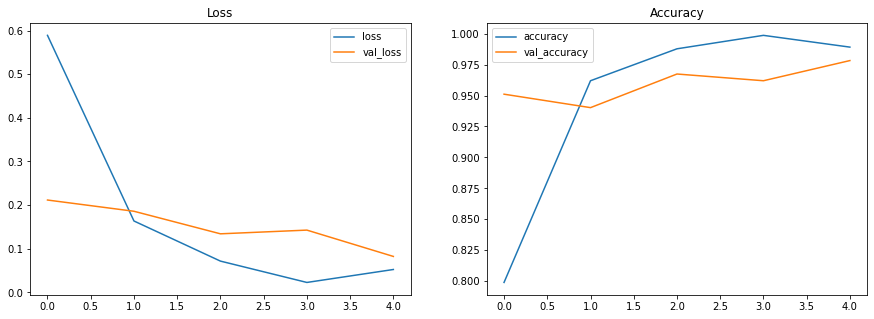

23/23 [==============================] - 3s 147ms/step - loss: 0.0822 - accuracy: 0.9783
[0.08224465698003769, 0.97826087474823]


In [64]:
############################
# Training Params
############################
learning_rate = 2e-5             # IMPORTANT: keeep learning rate low to not distort pretrained weights too much
epochs = 5

# Free up memory
K.clear_session()

# Build the model
model = build_pretrained_bert(num_classes)

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-08)
# Loss
loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True)

# Compile
model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=['accuracy'])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data,
        validation_data=validation_data,
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

evaluate_save_model(model,validation_data, training_results,execution_time, learning_rate, BATCH_SIZE, epochs, optimizer,save=True)

### **Compare all Models**

In [65]:
models_metrics_list = glob(experiment_name+"/*_model_metrics.json")

all_models_metrics = []
for mm_file in models_metrics_list:
  with open(mm_file) as json_file:
    model_metrics = json.load(json_file)
    all_models_metrics.append(model_metrics)

# Load metrics to dataframe
view_metrics = pd.DataFrame(data=all_models_metrics)

# Format columns
view_metrics['accuracy'] = view_metrics['accuracy']*100
view_metrics['accuracy'] = view_metrics['accuracy'].map('{:,.2f}%'.format)

view_metrics['trainable_parameters'] = view_metrics['trainable_parameters'].map('{:,.0f}'.format)
view_metrics['execution_time'] = view_metrics['execution_time'].map('{:,.2f} mins'.format)
view_metrics['loss'] = view_metrics['loss'].map('{:,.2f}'.format)
view_metrics['model_size'] = view_metrics['model_size']/1000000
view_metrics['model_size'] = view_metrics['model_size'].map('{:,.0f} MB'.format)

# Filter columns
view_metrics = view_metrics[["trainable_parameters","execution_time","loss",
                             "accuracy","model_size","learning_rate","epochs","name"]]
view_metrics = view_metrics.sort_values(by=['accuracy'],ascending=False)
view_metrics.head(10)

,trainable_parameters,execution_time,loss,accuracy,model_size,learning_rate,epochs,name
0,"109,484,547",3.92 mins,0.08,97.83%,438 MB,0.00002,5,bert_pretrained
1,"17,199,619",0.05 mins,1.66,92.93%,69 MB,0.01000,10,binary_1gram
5,"17,199,619",0.04 mins,4.61,88.59%,69 MB,0.01000,10,binary_2gram
2,"46,595",0.17 mins,0.74,58.70%,6 MB,0.01000,10,lstm_pretrained_emb
4,"1,546,595",2.74 mins,2.84,58.15%,6 MB,0.01000,10,lstm_model_emb
3,"2,863,619",0.03 mins,2.88,29.89%,11 MB,0.01000,10,simple_fcn


## **Text Generation using Language Model: GPT2** 

### **GPT2 Pretrained Lanaguage Model** <div id='gpt2_pretrained'>

**Tokenizer for GPT2**

In [66]:
# Tokenizer - Load the tokenizer specific to gpt2 training
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")

Downloading: 100%|██████████| 0.99M/0.99M [00:00<00:00, 66.9MB/s]
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 72.5MB/s]
Downloading: 100%|██████████| 665/665 [00:00<00:00, 463kB/s]


**Load GPT2 Pretrained Model**

In [67]:
# Model - Load pretrained GPT Language Model
model = TFGPT2LMHeadModel.from_pretrained("gpt2", pad_token_id=tokenizer.eos_token_id)

Downloading: 100%|██████████| 475M/475M [00:11<00:00, 41.8MB/s] 
2022-04-16 04:38:54.294152: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at gpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


In [68]:
# Input text
input_text = "Summer is almost here" # enter a prompt here

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')

# Generate output
outputs = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=100, 
    top_p=0.80, 
    top_k=0
)

print("Generated text:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Generated text:
Summer is almost here, but there is still much to do, and we'll get to it in a bit.

Q: So why does it seem that every player in this league really want to finish better than anyone else?

The answer is probably that the players that we're used to playing at have failed to adapt to the new coaching style and the competition.

Q: Why is this important? Why do I have to draft one of the other top talent in this league


### **Finetune GPT-2 Lanaguage Model** 

### **Overview**

In this section, we're going to be working with news articles from CNN related to covid-19. We will explore the dataset, prepare the data for finetuning GPT2. Our fine-tuned GPT2 will be able to write articles related to covid-19.

**The Task:** Finetune GPT2 to build a language model on news articles related to health, specifically covid-19 related articles.


#### **Download Dataset**

Download the datasets to colab.

In [69]:
start_time = time.time()
# Download
dataset_path = tf.keras.utils.get_file(
    origin="https://storage.googleapis.com/cs109b/datasets/covid.zip",
    extract=True)
dataset_path = dataset_path.replace(".zip","")
print("dataset_path:",dataset_path)
execution_time = (time.time() - start_time)/60.0
print("Download execution time (mins)",execution_time)

6053888/6038181 [==============================] - 0s 0us/step
dataset_path: /home/u_61397728/.keras/datasets/covid
Download execution time (mins) 0.3350569208463033


#### **Load Data**

* Read-in data as lists.

In [70]:
# Load all the paths to text files
training_data = []
text_files = os.listdir(dataset_path)
training_data.extend([os.path.join(dataset_path,f) for f in text_files])

# Subset your training data for demo, full datset can take a long time to train
subset_data = True
if subset_data:
  training_data = training_data[:300]

# Load the text content
for idx, path in enumerate(training_data):
  # Load text
  with open(path) as file:
    training_data[idx] = file.read()

print("training_data count:",len(training_data))

training_data count: 300


#### **View Text**

Let's take a look at the data.

In [71]:
# Generate a random sample of index
data_samples = np.random.randint(0,high=len(training_data)-1, size=10)
for i,data_idx in enumerate(data_samples):
  print("Text:",training_data[data_idx])

Text: How to train yourself not to touch your face   (CNN)We're washing our hands, staying at home and standing 6 feet apart when we do need to go out. What else can we do to limit the spread of Covid-19?  Public health experts say not enough is being done to tackle face touching -- something that could make a very large difference to the transmission of the coronavirus.   The challenge, says Susan Michie, the director of the Centre for Behaviour Change at University College London, is frustratingly simple. It's much, much harder not to do something than to do something.  "Do wash your hands, do stand 2 meters apart -- but don't touch your face? It's much more difficult," Michie says. We touch our face for many reasons: to groom, to gesture (like with the classic face palm) and to scratch. It can even be soothing in times of stress. According to one study, people touch their face about 23 times an hour.  To overcome these ingrained habits, Michie recommends making a conscious effort to

#### **Tokenize data for GPT2**

We will use the `distilgpt2` version of pre trained GPT2 model to tokenize text

In [72]:
# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained("distilgpt2")

# Tokenize data
training_data_tokenized = []
for data in training_data:
  tokenized_text = tokenizer.encode(data)
  training_data_tokenized.append(tokenized_text)

print(len(training_data_tokenized))
print(len(training_data_tokenized[0]),training_data_tokenized[0][:20])

Downloading: 100%|██████████| 0.99M/0.99M [00:00<00:00, 56.2MB/s]
Downloading: 100%|██████████| 446k/446k [00:00<00:00, 49.9MB/s]
Downloading: 100%|██████████| 762/762 [00:00<00:00, 376kB/s]
Token indices sequence length is longer than the specified maximum sequence length for this model (2216 > 1024). Running this sequence through the model will result in indexing errors


300
2216 [40229, 1195, 5, 32, 351, 1583, 13, 2986, 33708, 42095, 290, 8124, 7578, 10277, 25, 2744, 261, 615, 19397, 9905]


#### **Generate Training Data**

For the training we need inputs and lables but we only have news article texts. In lecture we learnt that language models are trained in a semi supervised way where we generate inputs and labels from the input text. 

<br>

To generate inputs and lables for training we will chunk the input text into blocks of size `100`. Then our labels will be the same as inputs but one position shifted to the right.

In [73]:
# Split into blocks
training_chunks = []
block_size = 100
for tokenized_text in training_data_tokenized:
  for i in range(0, len(tokenized_text) - block_size + 1, block_size):  # Truncate in block of block_size
      training_chunks.append(tokenized_text[i:i + block_size])

# Generate inputs and labels
inputs = []
labels = []
for ex in training_chunks:
    inputs.append(ex[:-1])
    labels.append(ex[1:])

print("inputs length:",len(inputs))
print("labels length:",len(labels))

inputs length: 3929
labels length: 3929


In [74]:
print("input:",len(inputs[0]),inputs[0][:20])
print("labels:",len(labels[0]),labels[0][:20])

input: 99 [40229, 1195, 5, 32, 351, 1583, 13, 2986, 33708, 42095, 290, 8124, 7578, 10277, 25, 2744, 261, 615, 19397, 9905]
labels: 99 [1195, 5, 32, 351, 1583, 13, 2986, 33708, 42095, 290, 8124, 7578, 10277, 25, 2744, 261, 615, 19397, 9905, 329]


In [75]:
BATCH_SIZE = 12
TRAIN_SHUFFLE_BUFFER_SIZE = len(inputs)

# Create TF Dataset
train_data = tf.data.Dataset.from_tensor_slices((inputs, labels))

#############
# Train data
#############
train_data = train_data.shuffle(buffer_size=TRAIN_SHUFFLE_BUFFER_SIZE)
train_data = train_data.batch(BATCH_SIZE, drop_remainder=True)
train_data = train_data.prefetch(buffer_size=AUTOTUNE)

print("train_data",train_data)

train_data <PrefetchDataset element_spec=(TensorSpec(shape=(12, 99), dtype=tf.int32, name=None), TensorSpec(shape=(12, 99), dtype=tf.int32, name=None))>


#### **Train/Finetune GPT2 Pretrained Model**

In [ ]:
############################
# Training Params
############################
learning_rate = 3e-5 
epsilon=1e-08
clipnorm=1.0
epochs = 30

# Free up memory
K.clear_session()

# Build the model
model = TFGPT2LMHeadModel.from_pretrained("distilgpt2")

# Print the model architecture
print(model.summary())

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=epsilon, clipnorm=clipnorm)
# Loss
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

# Compile
model.compile(loss=[loss, *[None] * model.config.n_layer],
                  optimizer=optimizer,
                  metrics=[metric])

# Train model
start_time = time.time()
training_results = model.fit(
        train_data, # train_data.take(1000) for testing
        epochs=epochs, 
        verbose=1)
execution_time = (time.time() - start_time)/60.0
print("Training execution time (mins)",execution_time)

Downloading: 100%|██████████| 313M/313M [00:07<00:00, 43.2MB/s] 
All model checkpoint layers were used when initializing TFGPT2LMHeadModel.

All the layers of TFGPT2LMHeadModel were initialized from the model checkpoint at distilgpt2.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFGPT2LMHeadModel for predictions without further training.


Model: "tfgpt2lm_head_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 transformer (TFGPT2MainLaye  multiple                 81912576  
 r)                                                              
                                                                 
Total params: 81,912,576
Trainable params: 81,912,576
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/30
327/327 [==============================] - 92s 257ms/step - loss: 3.5648 - logits_loss: 3.5648 - logits_accuracy: 0.3336 - past_key_values_1_accuracy: 0.0015 - past_key_values_2_accuracy: 0.0013 - past_key_values_3_accuracy: 0.0025 - past_key_values_4_accuracy: 0.0017 - past_key_values_5_accuracy: 0.0012 - past_key_values_6_accuracy: 0.0012
Epoch 2/30
327/327 [==============================] - 85s 261ms/step - loss: 3.3381 - logits_loss: 3.3381 - logits_accuracy: 0.3542 - past

#### **Generate Text**

In [ ]:
# Input text
input_text = "how is covid affecting"

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')
print("input_ids",input_ids)

# Generate outout
outputs = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=75, 
    top_p=0.80, 
    top_k=0
)

print("Generated text:")
display(tokenizer.decode(outputs[0], skip_special_tokens=True))

In [ ]:
# Input text
input_text = "the global pandemic"

# Tokenize Input
input_ids = tokenizer.encode(input_text, return_tensors='tf')

# Generate outout
outputs = model.generate(
    input_ids, 
    do_sample=True, 
    max_length=75, 
    top_p=0.80, 
    top_k=0
)

print("Generated text:")
display(tokenizer.decode(outputs[0], skip_special_tokens=True))